Madusanka Madiligama
01/05/2024

In [1]:
# library imports
import os
import gc
import io
import requests
import zipfile
import datetime

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#Configure plot aesthetics for matplotlib and seaborn.
def set_plot_aesthetics():

    plt.rcParams['figure.figsize'] = (10, 8)  
    plt.rcParams['xtick.labelsize'] = 13      
    plt.rcParams['ytick.labelsize'] = 13      
    plt.rcParams['axes.labelsize'] = 14       
    sns.set_palette('Dark2')                  

# Apply the plot settings
set_plot_aesthetics()
colors = list(sns.color_palette('Dark2'))    


In [3]:
# download the data and extract it from zip file
# URL of the file to be downloaded
file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip'

# Specify the directory where you want to extract the files
extract_to_dir = 'Data'

# Send a GET request to the file URL
try:
    r = requests.get(file_url)
    r.raise_for_status()  # Raise an exception for HTTP errors

    # Extract the content of the zip file
    with zipfile.ZipFile(io.BytesIO(r.content)) as zf:
        zf.extractall(extract_to_dir)

    print("File downloaded and extracted successfully.")

except requests.exceptions.HTTPError as e:
    print(f"HTTP Error: {e}")
except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
except zipfile.BadZipFile as e:
    print(f"Error: The downloaded file is not a zip file or it is corrupted: {e}")


File downloaded and extracted successfully.


In [4]:
# read the CSV file for the air quality data from Dingling station
base_dir = 'Data/PRSA_Data_20130301-20170228'
file_name = 'PRSA_Data_Dingling_20130301-20170228.csv'
df = pd.read_csv(os.path.join(base_dir, file_name), encoding='ISO-8859-1')
df.head()

No  year  month  day  hour  PM2.5  PM10  SO2  NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0  3.0  NaN  200.0  82.0  -2.3   
1   2  2013      3    1     1    7.0   7.0  3.0  NaN  200.0  80.0  -2.5   
2   3  2013      3    1     2    5.0   5.0  3.0  2.0  200.0  79.0  -3.0   
3   4  2013      3    1     3    6.0   6.0  3.0  NaN  200.0  79.0  -3.6   
4   5  2013      3    1     4    5.0   5.0  3.0  NaN  200.0  81.0  -3.5   

     PRES  DEWP  RAIN   wd  WSPM   station  
0  1020.8 -19.7   0.0    E   0.5  Dingling  
1  1021.3 -19.0   0.0  ENE   0.7  Dingling  
2  1021.3 -19.9   0.0  ENE   0.2  Dingling  
3  1021.8 -19.1   0.0  NNE   1.0  Dingling  
4  1022.3 -19.4   0.0    N   2.1  Dingling

In [5]:


def combine_and_convert_to_datetime(df):
    # Combine the year, month, day, and hour columns into a single string column
    df['datetime'] = df['year'].astype(str) + " " + df['month'].astype(str) + " " + \
                     df['day'].astype(str) + " " + df['hour'].astype(str)

    # Convert the combined string to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y %m %d %H')

    return df


# Apply the function
df = combine_and_convert_to_datetime(df)
# Drop the original columns
df.drop(columns=['No', 'year', 'month', 'day', 'hour'], inplace=True)
df.head(5)

PM2.5  PM10  SO2  NO2     CO    O3  TEMP    PRES  DEWP  RAIN   wd  WSPM  \
0    4.0   4.0  3.0  NaN  200.0  82.0  -2.3  1020.8 -19.7   0.0    E   0.5   
1    7.0   7.0  3.0  NaN  200.0  80.0  -2.5  1021.3 -19.0   0.0  ENE   0.7   
2    5.0   5.0  3.0  2.0  200.0  79.0  -3.0  1021.3 -19.9   0.0  ENE   0.2   
3    6.0   6.0  3.0  NaN  200.0  79.0  -3.6  1021.8 -19.1   0.0  NNE   1.0   
4    5.0   5.0  3.0  NaN  200.0  81.0  -3.5  1022.3 -19.4   0.0    N   2.1   

    station            datetime  
0  Dingling 2013-03-01 00:00:00  
1  Dingling 2013-03-01 01:00:00  
2  Dingling 2013-03-01 02:00:00  
3  Dingling 2013-03-01 03:00:00  
4  Dingling 2013-03-01 04:00:00

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   PM2.5     34285 non-null  float64       
 1   PM10      34408 non-null  float64       
 2   SO2       34334 non-null  float64       
 3   NO2       33830 non-null  float64       
 4   CO        33052 non-null  float64       
 5   O3        33850 non-null  float64       
 6   TEMP      35011 non-null  float64       
 7   PRES      35014 non-null  float64       
 8   DEWP      35011 non-null  float64       
 9   RAIN      35013 non-null  float64       
 10  wd        34924 non-null  object        
 11  WSPM      35021 non-null  float64       
 12  station   35064 non-null  object        
 13  datetime  35064 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(11), object(2)
memory usage: 3.7+ MB


In [7]:
#Calculate the number and percentage of missing values in each column of a DataFrame.
def missing_values(df):

    data = pd.DataFrame(df.isnull().sum())
    data.columns = ['# missing']
    data['% missing'] = np.round((100 * data['# missing']) / df.shape[0], 2)
    return data


In [8]:
def data_overview(df):
    """Prints a comprehensive overview of a pandas DataFrame."""

    print(f'Rows: {df.shape[0]}')
    print(f'Columns: {df.shape[1]}')

    print("\nFeatures:")
    print('-'*10)
    print(df.columns.tolist())

    print('\nMissing Values:')
    print('-'*15)
    print(missing_values(df))

    print('\nUnique Values:')
    print('-'*15)
    print(df.nunique())

    print('\nFirst 5 Rows:')
    print('-'*15)
    print(df.head())

    print('\nData Types:')
    print('-'*15)
    print(df.dtypes)

    print('\nDescriptive Statistics:')
    print('-'*25)
    print(df.describe(include='all'))

    print('\nValue Counts for Categorical Columns:')
    print('-'*35)
    for col in df.select_dtypes(include='object').columns:
        print(f'\nValue counts of column {col}:')
        print(df[col].value_counts())

# Usage
data_overview(df)


Rows: 35064
Columns: 14

Features:
----------
['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'datetime']

Missing Values:
---------------
          # missing  % missing
PM2.5           779       2.22
PM10            656       1.87
SO2             730       2.08
NO2            1234       3.52
CO             2012       5.74
O3             1214       3.46
TEMP             53       0.15
PRES             50       0.14
DEWP             53       0.15
RAIN             51       0.15
wd              140       0.40
WSPM             43       0.12
station           0       0.00
datetime          0       0.00

Unique Values:
---------------
PM2.5         486
PM10          554
SO2           327
NO2           636
CO            103
O3            792
TEMP          998
PRES          593
DEWP          602
RAIN          116
wd             16
WSPM           95
station         1
datetime    35064
dtype: int64

First 5 Rows:
---------------
   PM2.5  PM10 

In [9]:
# filtering out the rows with null values of `PM2.5`
df[df['PM2.5'].isnull()]

PM2.5  PM10   SO2   NO2  CO   O3  TEMP    PRES  DEWP  RAIN   wd  WSPM  \
752      NaN   NaN   NaN   NaN NaN  NaN  11.0  1005.9  -3.2   0.0   NW   7.2   
753      NaN   NaN   NaN   NaN NaN  NaN  10.6  1007.0  -3.5   0.0  NNW   4.5   
754      NaN   NaN   NaN   NaN NaN  NaN  13.2  1007.8  -3.6   0.0  NNW   4.5   
755      NaN   NaN   NaN   NaN NaN  NaN  13.8  1007.7  -4.9   0.0  NNE   4.0   
756      NaN   NaN   NaN   NaN NaN  NaN  15.3  1007.9  -5.7   0.0   NE   5.0   
...      ...   ...   ...   ...  ..  ...   ...     ...   ...   ...  ...   ...   
34863    NaN   NaN   NaN   NaN NaN  NaN   4.2  1022.0 -21.0   0.0  WNW   3.1   
34864    NaN   NaN   NaN   NaN NaN  NaN   4.4  1022.1 -21.7   0.0  WNW   3.4   
34866    NaN   NaN   NaN   NaN NaN  NaN   3.3  1022.2 -20.9   0.0   NE   1.1   
34883    NaN   NaN  26.0  68.0 NaN  5.0  -0.5  1022.7 -16.0   0.0  ESE   1.9   
34885    NaN   NaN   NaN   NaN NaN  NaN  -1.0  1021.5  -9.4   0.0   SW   1.7   

        station            datetime  
752    Dingling 2013-04-01 08:00:00  
753    Dingling 2013-04-01 09:00:00  
754    Dingling 2013-04-01 10:00:00  
755    Dingling 2013-04-01 11:00:00  
756    Dingling 2013-04-01 12:00:00  
...         ...                 ...  
34863  Dingling 2017-02-20 15:00:00  
34864  Dingling 2017-02-20 16:00:00  
34866  Dingling 2017-02-20 18:00:00  
34883  Dingling 2017-02-21 11:00:00  
34885  Dingling 2017-02-21 13:00:00  

[779 rows x 14 columns]

In [10]:
# Assuming df['datetime'] is a pandas datetime series
df['datetime'] = np.array(df['datetime'].dt.to_pydatetime())


C:\Users\nikmb\AppData\Local\Temp\ipykernel_23516\2680125405.py:2: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df['datetime'] = np.array(df['datetime'].dt.to_pydatetime())


In [11]:

# Create a Plotly figure with improved layout settings
fig = go.Figure(
    data=go.Scatter(
        x=df['datetime'], 
        y=df['PM2.5'], 
        name='PM2.5', 
        mode='lines',
        text=df['datetime']
    ),
    layout=go.Layout(
        title='Time Series Analysis of PM2.5 Levels',
        xaxis=dict(
            title='Date and Time',
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(count=2, label="2y", step="year", stepmode="backward"),
                    dict(count=3, label="3y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type='date'
        ),
        yaxis=dict(title='PM2.5 Concentration'),
    )
)

# Show the figure
fig.show()


c:\Users\nikmb\.conda\envs\ts\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [12]:

#Create and display a time series plot for a specified column in the DataFrame.
def plot_time_series(df, column_name, title):

    # Create a Plotly figure
    fig = go.Figure(
        data=go.Scatter(
            x=df['datetime'], 
            y=df[column_name], 
            name=column_name, 
            mode='lines',
            text=df['datetime']
        ),
        layout=go.Layout(
            title=f'Time Series of {title}',
            xaxis=dict(
                title='Date and Time',
                rangeselector=dict(
                    buttons=list([
                        dict(count=1, label="1y", step="year", stepmode="backward"),
                        dict(count=2, label="2y", step="year", stepmode="backward"),
                        dict(count=3, label="3y", step="year", stepmode="backward"),
                        dict(step="all")
                    ])
                ),
                rangeslider=dict(visible=True),
                type='date'
            ),
            yaxis=dict(title=title)
        )
    )

    # Show the figure
    fig.show()




In [14]:
# Example usage: PM10
plot_time_series(df, 'PM10', 'PM10 Concentration')

In [15]:
## Example usage: O3
plot_time_series(df, 'O3', 'O3 Concentration')


o3 values are missing from 2016-07-02 to 2016-07-13

### Imputation techniques on the missing data


In [17]:
# setting the time stamp as index
df = df.set_index('datetime')

In [18]:
#select data for identified missing value period
df.loc['2016-07-01':'2016-07-15']

PM2.5  PM10  SO2  NO2     CO     O3  TEMP   PRES  DEWP  \
datetime                                                                      
2016-07-01 00:00:00    9.0   9.0  2.0  2.0  200.0   68.0  26.3  995.5  13.1   
2016-07-01 01:00:00    3.0   5.0  2.0  2.0  200.0   75.0  24.3  995.7  13.5   
2016-07-01 02:00:00    7.0   7.0  2.0  2.0  200.0   82.0  24.2  995.6  13.1   
2016-07-01 03:00:00    4.0  18.0  2.0  2.0  200.0   60.0  22.3  995.7  13.1   
2016-07-01 04:00:00    5.0   5.0  2.0  2.0  200.0   55.0  21.3  995.5  12.7   
...                    ...   ...  ...  ...    ...    ...   ...    ...   ...   
2016-07-15 19:00:00   21.0  21.0  2.0  2.0  400.0  101.0  20.7  994.5  17.5   
2016-07-15 20:00:00   16.0  16.0  2.0  2.0  400.0  104.0  20.6  994.5  17.6   
2016-07-15 21:00:00   17.0  17.0  2.0  2.0  400.0   91.0  20.3  994.6  17.7   
2016-07-15 22:00:00   19.0  19.0  2.0  2.0  400.0   71.0  20.2  994.6  17.8   
2016-07-15 23:00:00   19.0  19.0  2.0  2.0  400.0   53.0  20.3  994.7  17.7   

                     RAIN   wd  WSPM   station  
datetime                                        
2016-07-01 00:00:00   0.0  NNE   2.2  Dingling  
2016-07-01 01:00:00   0.0   NW   1.3  Dingling  
2016-07-01 02:00:00   0.0  NNE   1.7  Dingling  
2016-07-01 03:00:00   0.0    N   1.3  Dingling  
2016-07-01 04:00:00   0.0   NW   1.0  Dingling  
...                   ...  ...   ...       ...  
2016-07-15 19:00:00   0.0   NW   1.5  Dingling  
2016-07-15 20:00:00   0.0  NNW   0.9  Dingling  
2016-07-15 21:00:00   0.0   NW   0.8  Dingling  
2016-07-15 22:00:00   0.0  WNW   0.6  Dingling  
2016-07-15 23:00:00   0.0  WNW   1.1  Dingling  

[360 rows x 13 columns]

In [19]:
# creating another dataset without null values only for visualization
df_na = df.copy()
df_na = df_na.dropna()

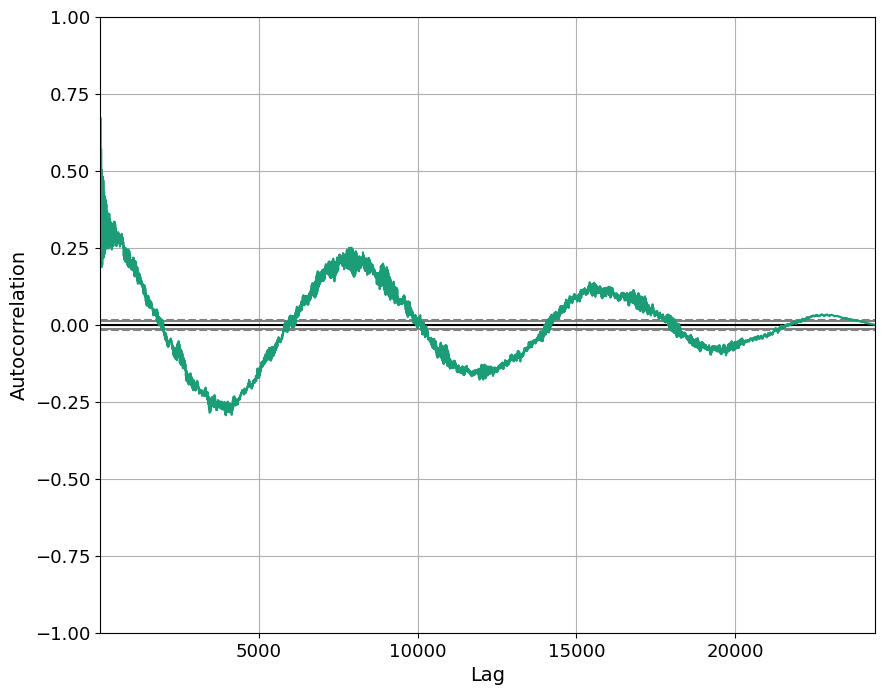

In [20]:
#autocorrelation plot for the 'O3' column from 2014 to 2016 to analyze patterns and seasonality in Ozone data.
pd.plotting.autocorrelation_plot(df_na['2014':'2016']['O3']);


When analyzing the autocorrelation plot of the O3 data, which is provided on an hourly basis, a notable observation is the peak around 
x=8700. This is a significant finding because there are 8760 hours in a year, suggesting that the O3 shows a high degree of correlation with its values approximately one year prior. This peak indicates a yearly seasonal pattern in the data, where similar O3 conditions recur on an annual cycle.

Furthermore, the plot reveals a decrease in autocorrelation as the lag time increases. This trend is logical as, over longer time lags, environmental conditions tend to show more variation, leading to a reduction in the predictability of the O3 based on past values. This diminishing autocorrelation with increasing lag is a common characteristic in many natural time series datasets, reflecting changing conditions over time.

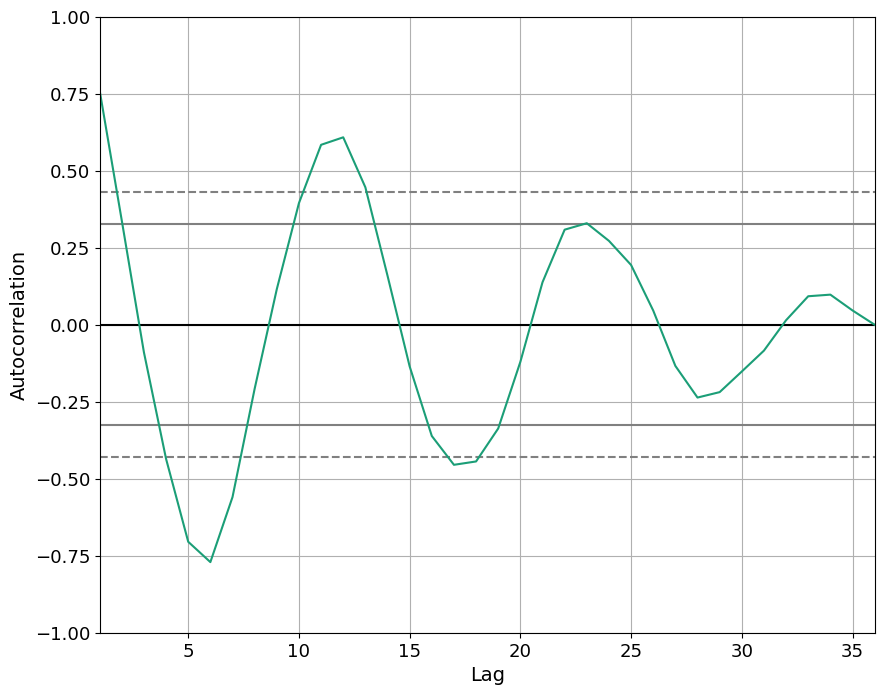

In [21]:
#autocorrelation plot for monthly averaged 'O3' data from 2014 to 2016 to identify seasonal patterns or trends in Ozone.
pd.plotting.autocorrelation_plot(df_na['2014':'2016']['O3'].resample('1m').mean());

In the autocorrelation plot, we observe recurrent peaks in correlation approximately every 12 months. These regular peaks are indicative of strong yearly seasonality in the data, suggesting that similar conditions or patterns repeat annually.

Additionally, the plot includes two horizontal lines representing confidence levels (CL) - a dotted line for the 90% confidence level and a solid line for the 95% confidence level. Points that lie above these lines are considered to be statistically significant. In other words, peaks in autocorrelation that cross these lines are not likely to be due to random chance and instead suggest meaningful patterns in the data. These confidence intervals are crucial for distinguishing between actual correlations in the data and those that might appear by chance.

### The correlation across different time lags

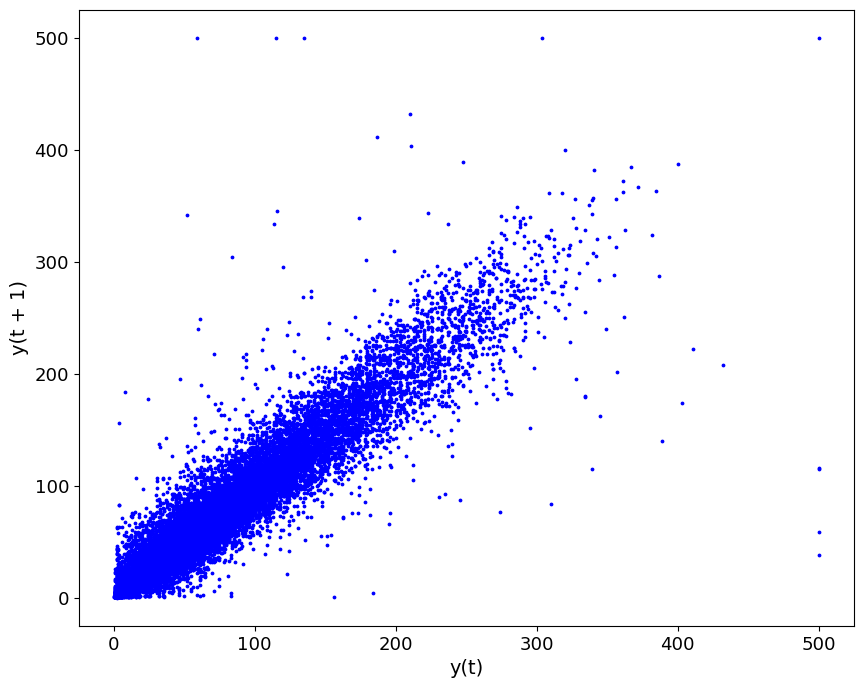

In [32]:
# lag plot for the 'O3' column  to visualize and analyze autocorrelation in Ozone data at a one-hour interval.
pd.plotting.lag_plot(df_na['O3'], lag=1, c='blue', marker='o', s=3);


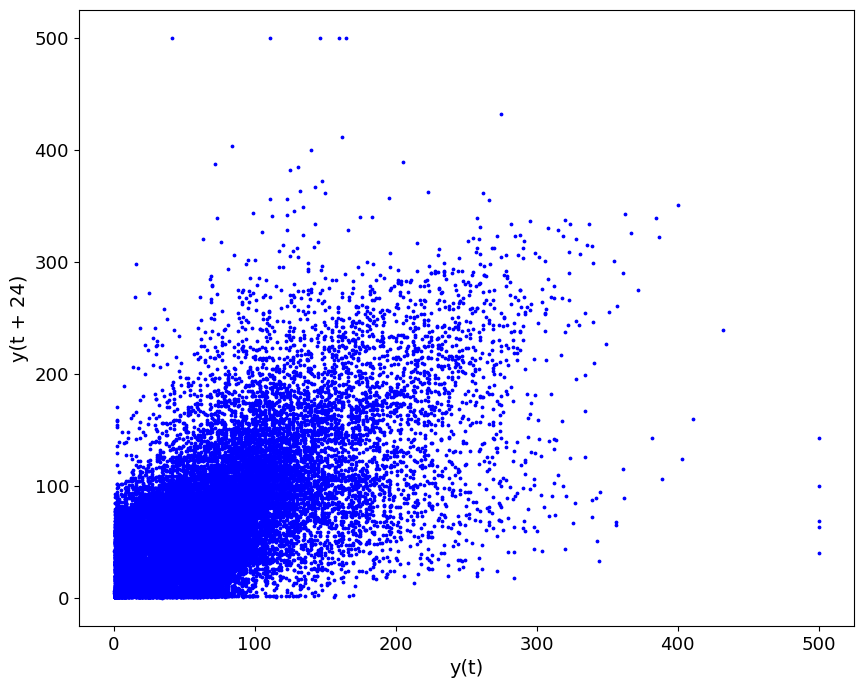

In [33]:
# lag plot for the 'O3' column  to visualize and analyze autocorrelation in Ozone data at a one-day interval.
pd.plotting.lag_plot(df_na['O3'], lag=24, c='blue', marker='o', s=3);

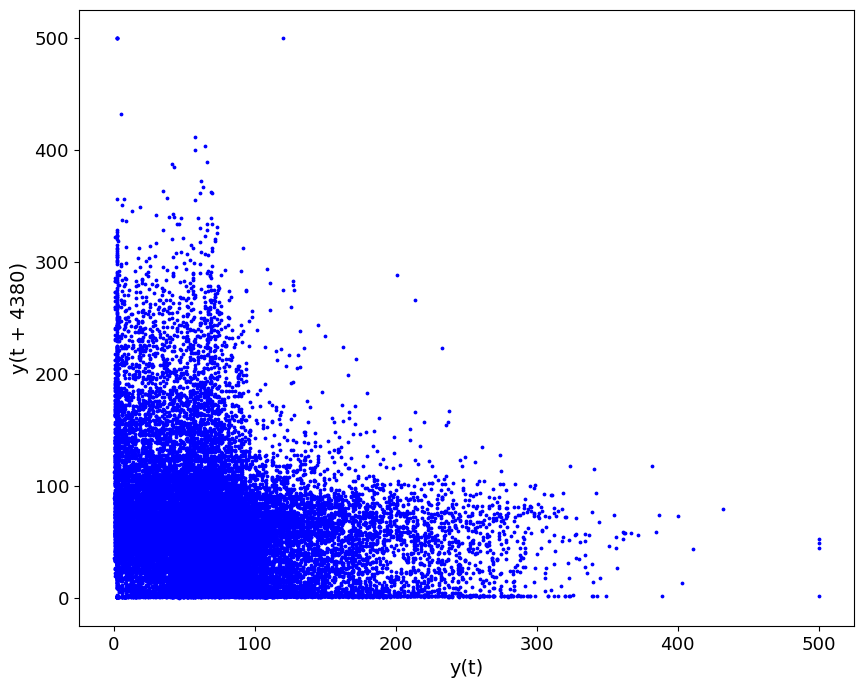

In [34]:
# lag plot for the 'O3' column  to visualize and analyze autocorrelation in Ozone data at a six-month interval.
pd.plotting.lag_plot(df_na['O3'], lag=4380, c='blue', marker='o', s=3);

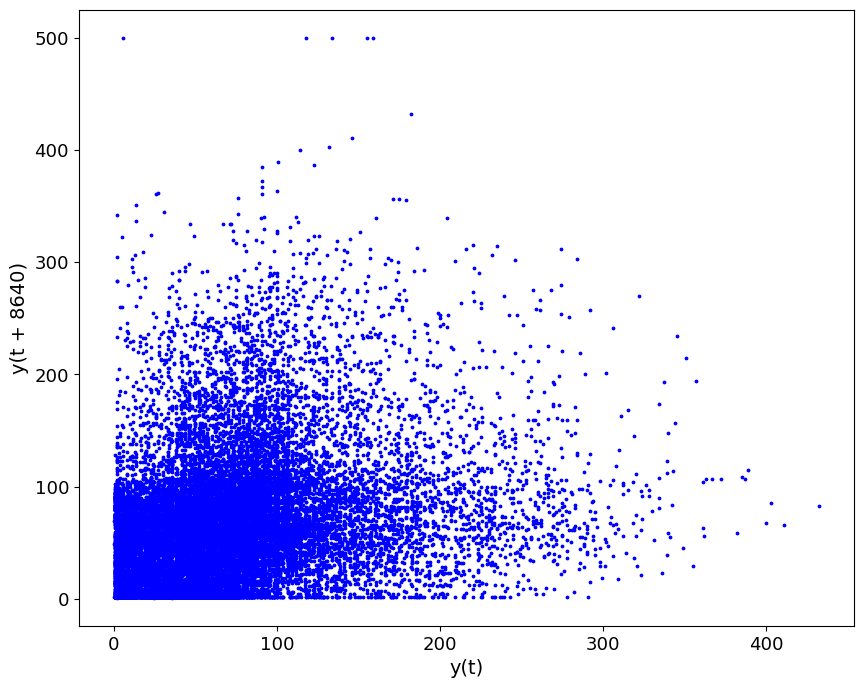

In [35]:
# lag plot for the 'O3' column  to visualize and analyze autocorrelation in Ozone data at a one-year interval.
pd.plotting.lag_plot(df_na['O3'], lag=8640, c='blue', marker='o', s=3);

The lag plots indicate a strong yearly seasonality in the data. While there is significant autocorrelation at lags of one hour and one day, suggesting that short-term imputation methods such as using the previous hour or day's data could be effective, the pronounced yearly pattern also suggests that incorporating seasonal imputation methods that account for this annual cycle might provide better imputation results for missing values.

### Imputing missing data

In [37]:
# creating a small subset of data containing the missing values
df_impute = df['2016-07-02 00':'2016-07-15 23'][['O3']]
df_impute

O3
datetime                  
2016-07-02 00:00:00  500.0
2016-07-02 01:00:00    NaN
2016-07-02 02:00:00  500.0
2016-07-02 03:00:00    NaN
2016-07-02 04:00:00    NaN
...                    ...
2016-07-15 19:00:00  101.0
2016-07-15 20:00:00  104.0
2016-07-15 21:00:00   91.0
2016-07-15 22:00:00   71.0
2016-07-15 23:00:00   53.0

[336 rows x 1 columns]

In [38]:
# creating a column with forward filled values for Ozone
df_impute['O3_FILL'] = df_impute['O3'].fillna(method='ffill')
df_impute

C:\Users\nikmb\AppData\Local\Temp\ipykernel_23516\908285638.py:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



O3  O3_FILL
datetime                           
2016-07-02 00:00:00  500.0    500.0
2016-07-02 01:00:00    NaN    500.0
2016-07-02 02:00:00  500.0    500.0
2016-07-02 03:00:00    NaN    500.0
2016-07-02 04:00:00    NaN    500.0
...                    ...      ...
2016-07-15 19:00:00  101.0    101.0
2016-07-15 20:00:00  104.0    104.0
2016-07-15 21:00:00   91.0     91.0
2016-07-15 22:00:00   71.0     71.0
2016-07-15 23:00:00   53.0     53.0

[336 rows x 2 columns]

In [39]:

# creating a column with backward filled values for Ozone
# not very recommended for predict the future
df_impute['TEMP_BFILL'] = df_impute['O3'].fillna(method='bfill')
df_impute

C:\Users\nikmb\AppData\Local\Temp\ipykernel_23516\2499350241.py:3: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



O3  O3_FILL  TEMP_BFILL
datetime                                       
2016-07-02 00:00:00  500.0    500.0       500.0
2016-07-02 01:00:00    NaN    500.0       500.0
2016-07-02 02:00:00  500.0    500.0       500.0
2016-07-02 03:00:00    NaN    500.0        38.0
2016-07-02 04:00:00    NaN    500.0        38.0
...                    ...      ...         ...
2016-07-15 19:00:00  101.0    101.0       101.0
2016-07-15 20:00:00  104.0    104.0       104.0
2016-07-15 21:00:00   91.0     91.0        91.0
2016-07-15 22:00:00   71.0     71.0        71.0
2016-07-15 23:00:00   53.0     53.0        53.0

[336 rows x 3 columns]

In [41]:
# take a rolling window to better account for the variability in the O3
df_impute['O3_ROLLING'] = df_impute['O3'].rolling(window=2, min_periods=1).mean()
df_impute

O3  O3_FILL  TEMP_BFILL  O3_ROLLING
datetime                                                   
2016-07-02 00:00:00  500.0    500.0       500.0       500.0
2016-07-02 01:00:00    NaN    500.0       500.0       500.0
2016-07-02 02:00:00  500.0    500.0       500.0       500.0
2016-07-02 03:00:00    NaN    500.0        38.0       500.0
2016-07-02 04:00:00    NaN    500.0        38.0         NaN
...                    ...      ...         ...         ...
2016-07-15 19:00:00  101.0    101.0       101.0        99.5
2016-07-15 20:00:00  104.0    104.0       104.0       102.5
2016-07-15 21:00:00   91.0     91.0        91.0        97.5
2016-07-15 22:00:00   71.0     71.0        71.0        81.0
2016-07-15 23:00:00   53.0     53.0        53.0        62.0

[336 rows x 4 columns]

In [42]:
df_impute = df_impute.reset_index()
df_impute

datetime     O3  O3_FILL  TEMP_BFILL  O3_ROLLING
0   2016-07-02 00:00:00  500.0    500.0       500.0       500.0
1   2016-07-02 01:00:00    NaN    500.0       500.0       500.0
2   2016-07-02 02:00:00  500.0    500.0       500.0       500.0
3   2016-07-02 03:00:00    NaN    500.0        38.0       500.0
4   2016-07-02 04:00:00    NaN    500.0        38.0         NaN
..                  ...    ...      ...         ...         ...
331 2016-07-15 19:00:00  101.0    101.0       101.0        99.5
332 2016-07-15 20:00:00  104.0    104.0       104.0       102.5
333 2016-07-15 21:00:00   91.0     91.0        91.0        97.5
334 2016-07-15 22:00:00   71.0     71.0        71.0        81.0
335 2016-07-15 23:00:00   53.0     53.0        53.0        62.0

[336 rows x 5 columns]

In [43]:

# impute only the missing values with the previous year's values
df_impute['O3_PREV_YEAR'] = df_impute.apply(lambda x: df.loc[x['datetime'] + 
                                  pd.offsets.DateOffset(years=-1)]['O3'] 
                 if pd.isna(x['O3']) else x['O3'], axis=1)
df_impute

datetime     O3  O3_FILL  TEMP_BFILL  O3_ROLLING  O3_PREV_YEAR
0   2016-07-02 00:00:00  500.0    500.0       500.0       500.0         500.0
1   2016-07-02 01:00:00    NaN    500.0       500.0       500.0          81.0
2   2016-07-02 02:00:00  500.0    500.0       500.0       500.0         500.0
3   2016-07-02 03:00:00    NaN    500.0        38.0       500.0          72.0
4   2016-07-02 04:00:00    NaN    500.0        38.0         NaN          66.0
..                  ...    ...      ...         ...         ...           ...
331 2016-07-15 19:00:00  101.0    101.0       101.0        99.5         101.0
332 2016-07-15 20:00:00  104.0    104.0       104.0       102.5         104.0
333 2016-07-15 21:00:00   91.0     91.0        91.0        97.5          91.0
334 2016-07-15 22:00:00   71.0     71.0        71.0        81.0          71.0
335 2016-07-15 23:00:00   53.0     53.0        53.0        62.0          53.0

[336 rows x 6 columns]